In [162]:
from cProfile import label
import sys
import json
import math
import os
import ast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

import os
import seaborn as sns

In [ ]:
data[group] = { 'rank':int, #accending rank of team score (1 lowest)
        'directory':str, #drectory to save files easier'
        'imp_rank':int,#rank of how much they improved ep1vs2 (1 lowest improvemnt or worsening)
        '1': {'rank':int,#same as above for all episodes
                    'meds': dataframe of medics,
                    'engs':dataframe of engs, 
                    'directory':str,#same as above
                    'med_playerid':dataframe of player,
                    'eng_player_id':dataframe of player,
                    'global':team dataframe of episode
                    }

}

In [223]:
directory ='/Users/josecordova/Desktop/Michigan/545/project/TED-Minimap/output/'# '/Users/josecordova/Documents/cmu/TED'
os.chdir(directory)
labels = ['Workload','Skill','Effort']
lims=[1,0.8,1]


data = {}
episodes_score = {}
group_scores = {}
improvement_score = {}
size=10
df_global = pd.DataFrame(0, index=np.arange(size), columns=labels)
df_eng_global = pd.DataFrame(0, index=np.arange(size), columns=labels)
df_med_global = pd.DataFrame(0, index=np.arange(size), columns=labels)
df_ep1 = pd.DataFrame(0, index=np.arange(size), columns=labels)
df_ep2 = pd.DataFrame(0, index=np.arange(size), columns=labels)
eng_global=0
med_global=0
time=range(0,290,10)
for group in sorted(os.listdir(directory)):
    if '.' in group: 
        continue
    data[group]={}
    data[group]['1'] = {}
    data[group]['2'] = {}

    curr_directory = directory+group+'/'
    data[group]['directory']=curr_directory
    data[group]['meds'] = pd.DataFrame(0, index=np.arange(size), columns=labels)
    data[group]['engs'] = pd.DataFrame(0, index=np.arange(size), columns=labels)

    for episode in sorted(os.listdir(curr_directory)):

        if '.' in episode: 
            continue
        data[group][episode]['directory'] = curr_directory +episode+'/'
        data[group][episode]['label'] = group + '_' +episode
        data[group][episode]['global'] = pd.read_csv(group+'/' +episode +'_global.csv')
        data[group][episode]['score']= (50*data[group][episode]['global']['triage_count_red']+data[group][episode]['global']['triage_count_yellow']*30 \
            +data[group][episode]['global']['triage_count_green']*10).sum()

        data[group][episode]['global'] =data[group][episode]['global'].groupby(np.arange(len(data[group][episode]['global']))//3).mean()

        data[group][episode]['global']['time'] = range(0,10*len(data[group][episode]['global']),10)



        data[group][episode]['global'].rename(columns = {'process_skill_use_s':'Skill', 'process_effort_s':'Effort','process_workload_burnt':'Workload'}, inplace = True)

        episodes_score[group+'_'+episode] = data[group][episode]['score']

        for proccess in labels:
            data[group][episode][proccess] = data[group][episode]['global'][proccess].sum()
            df_global[proccess]+=data[group][episode]['global'][proccess]
        
        if episode == '1':
            
            df_ep1[labels]+=data[group][episode]['global'][labels]
        else:
            df_ep2[labels]+=data[group][episode]['global'][labels]

        directory_episode = curr_directory+episode+'/'
        data[group][episode]['meds'] = pd.DataFrame(0, index=np.arange(size), columns=labels)
        data[group][episode]['engs'] = pd.DataFrame(0, index=np.arange(size), columns=labels)
        engs = 0
        meds = 0
        for player in os.listdir(directory_episode):
            if not player.endswith(".csv") : 
                continue
            curr_player = directory_episode+player
            data[group][episode][player[:-4]]= pd.read_csv(curr_player)
            data[group][episode][player[:-4]]=data[group][episode][player[:-4]].groupby(np.arange(len(data[group][episode][player[:-4]]))//3).mean()

            data[group][episode][player[:-4]].rename(columns = {'skill_s':'Skill', 'effort':'Effort','workload':'Workload'}, inplace = True)
            try:
                data[group][player[:-4]][labels]+=data[group][episode][player[:-4]]
                data[group][player[:-4]][labels]/=2
            except:
                data[group][player[:-4]]=data[group][episode][player[:-4]]




            if player[0] == 'e':
                engs+=1
                eng_global+=1
                for metric in labels:
                    data[group][episode]['engs'][metric]+=data[group][episode][player[:-4]][metric]
                    df_eng_global[metric]+=data[group][episode][player[:-4]][metric]

            else:
                meds+=1
                med_global+=1
                for metric in labels:
                    data[group][episode]['meds'][metric]+=data[group][episode][player[:-4]][metric]
                    df_med_global[metric]+=data[group][episode][player[:-4]][metric]

                    

        data[group][episode]['engs']/=engs
        data[group][episode]['meds']/=meds

        data[group]['engs'][labels]+=data[group][episode]['engs'][labels]
        data[group]['meds'][labels]+=data[group][episode]['meds'][labels]
    data[group]['meds']/=2
    data[group]['engs']/=2

    data[group]['score']=data[group]['1']['score'] + data[group]['2']['score']
    group_scores[group]=data[group]['score']

    data[group]['imp_score']=data[group]['2']['score'] - data[group]['1']['score']
    improvement_score[group]=data[group]['imp_score']

df_eng_global /=eng_global
df_med_global/=med_global
df_med_global['Time'] = range(0,10*len(df_med_global),10)
df_eng_global['Time'] = range(0,10*len(df_eng_global),10)

df_ep1/=len(data)
df_ep2/=len(data)

df_global /= len(data)*2
df_global['Time'] = range(0,10*len(df_global),10)
df_global['CI'] = df_global['Workload']+df_global['Skill']+df_global['Effort']
episodes_score = dict(sorted(episodes_score.items(), key=lambda item: item[1]))
df = pd.DataFrame(episodes_score.items())
df.to_csv('ep_scores.csv',index=False)
group_scores = dict(sorted(group_scores.items(), key=lambda item: item[1]))
df = pd.DataFrame(group_scores.items())
df.to_csv('group_scores.csv',index=False)
improvement_score = dict(sorted(improvement_score.items(), key=lambda item: item[1]))
df = pd.DataFrame(improvement_score.items())
df.to_csv('imp_scores.csv',index=False)



i=0
for episode in episodes_score:
    data[episode[:-2]][episode[-1]]['rank']=i
    i+=1
i=0
for group in group_scores:
    data[group]['rank']=len(data)-1-i
    i+=1
i=0
for group in improvement_score:
    data[group]['impr_rank']=i
    i+=1

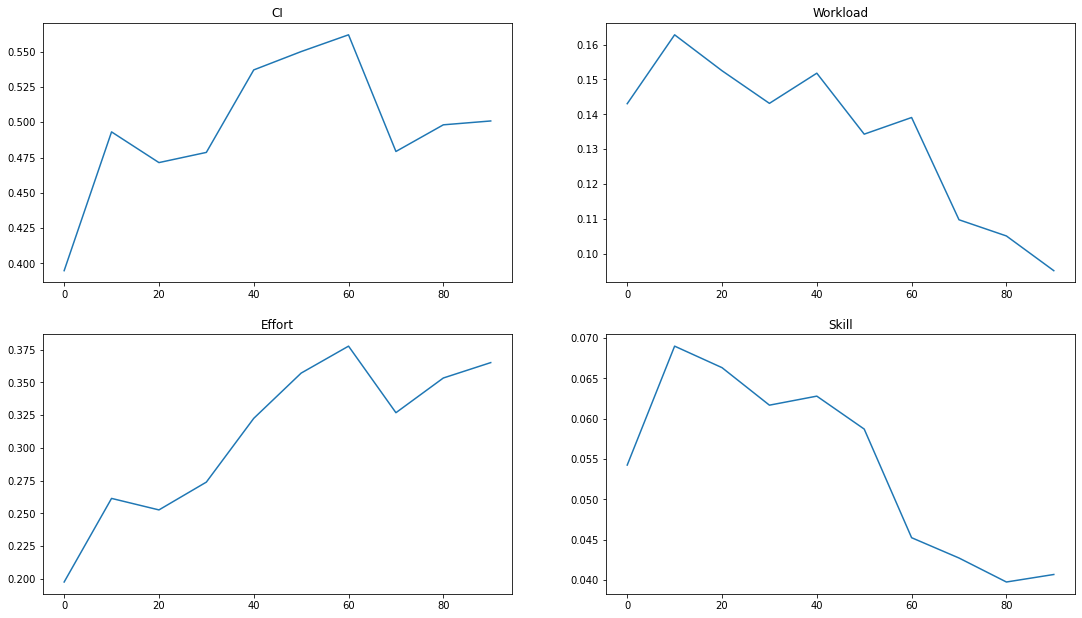

In [218]:
figure, axis = plt.subplots(2, 2)
figure.set_size_inches(18.5, 10.5)

axis[0, 0].plot(df_global['Time'], df_global['CI'])
axis[0, 0].set_title("CI")
  
axis[0, 1].plot(df_global['Time'], df_global['Workload'])
axis[0, 1].set_title("Workload")
  
axis[1, 0].plot(df_global['Time'], df_global['Effort'])
axis[1, 0].set_title("Effort")
  
axis[1, 1].plot(df_global['Time'], df_global['Skill'])
axis[1, 1].set_title("Skill")
  
plt.show()

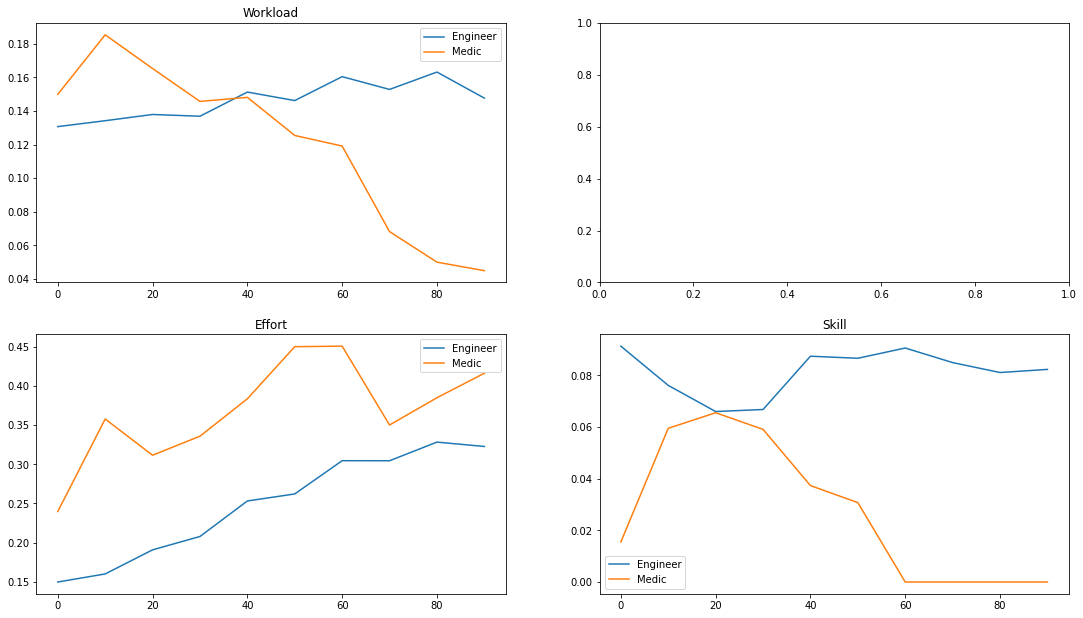

In [182]:
figure, axis = plt.subplots(2, 2)
figure.set_size_inches(18.5, 10.5)

  
axis[0, 0].plot(df_eng_global['Time'], df_eng_global['Workload'],label='Engineer')
axis[0, 0].plot(df_med_global['Time'], df_med_global['Workload'],label='Medic')
axis[0, 0].legend()
axis[0, 0].set_title("Workload")

axis[1, 0].plot(df_eng_global['Time'], df_eng_global['Effort'],label='Engineer')
axis[1, 0].plot(df_med_global['Time'], df_med_global['Effort'],label='Medic')
axis[1, 0].legend()


axis[1, 0].set_title("Effort")

axis[1, 1].plot(df_eng_global['Time'], df_eng_global['Skill'],label='Engineer')
axis[1, 1].plot(df_med_global['Time'], df_med_global['Skill'],label='Medic')  
axis[1, 1].set_title("Skill")
axis[1, 1].legend()

plt.show()

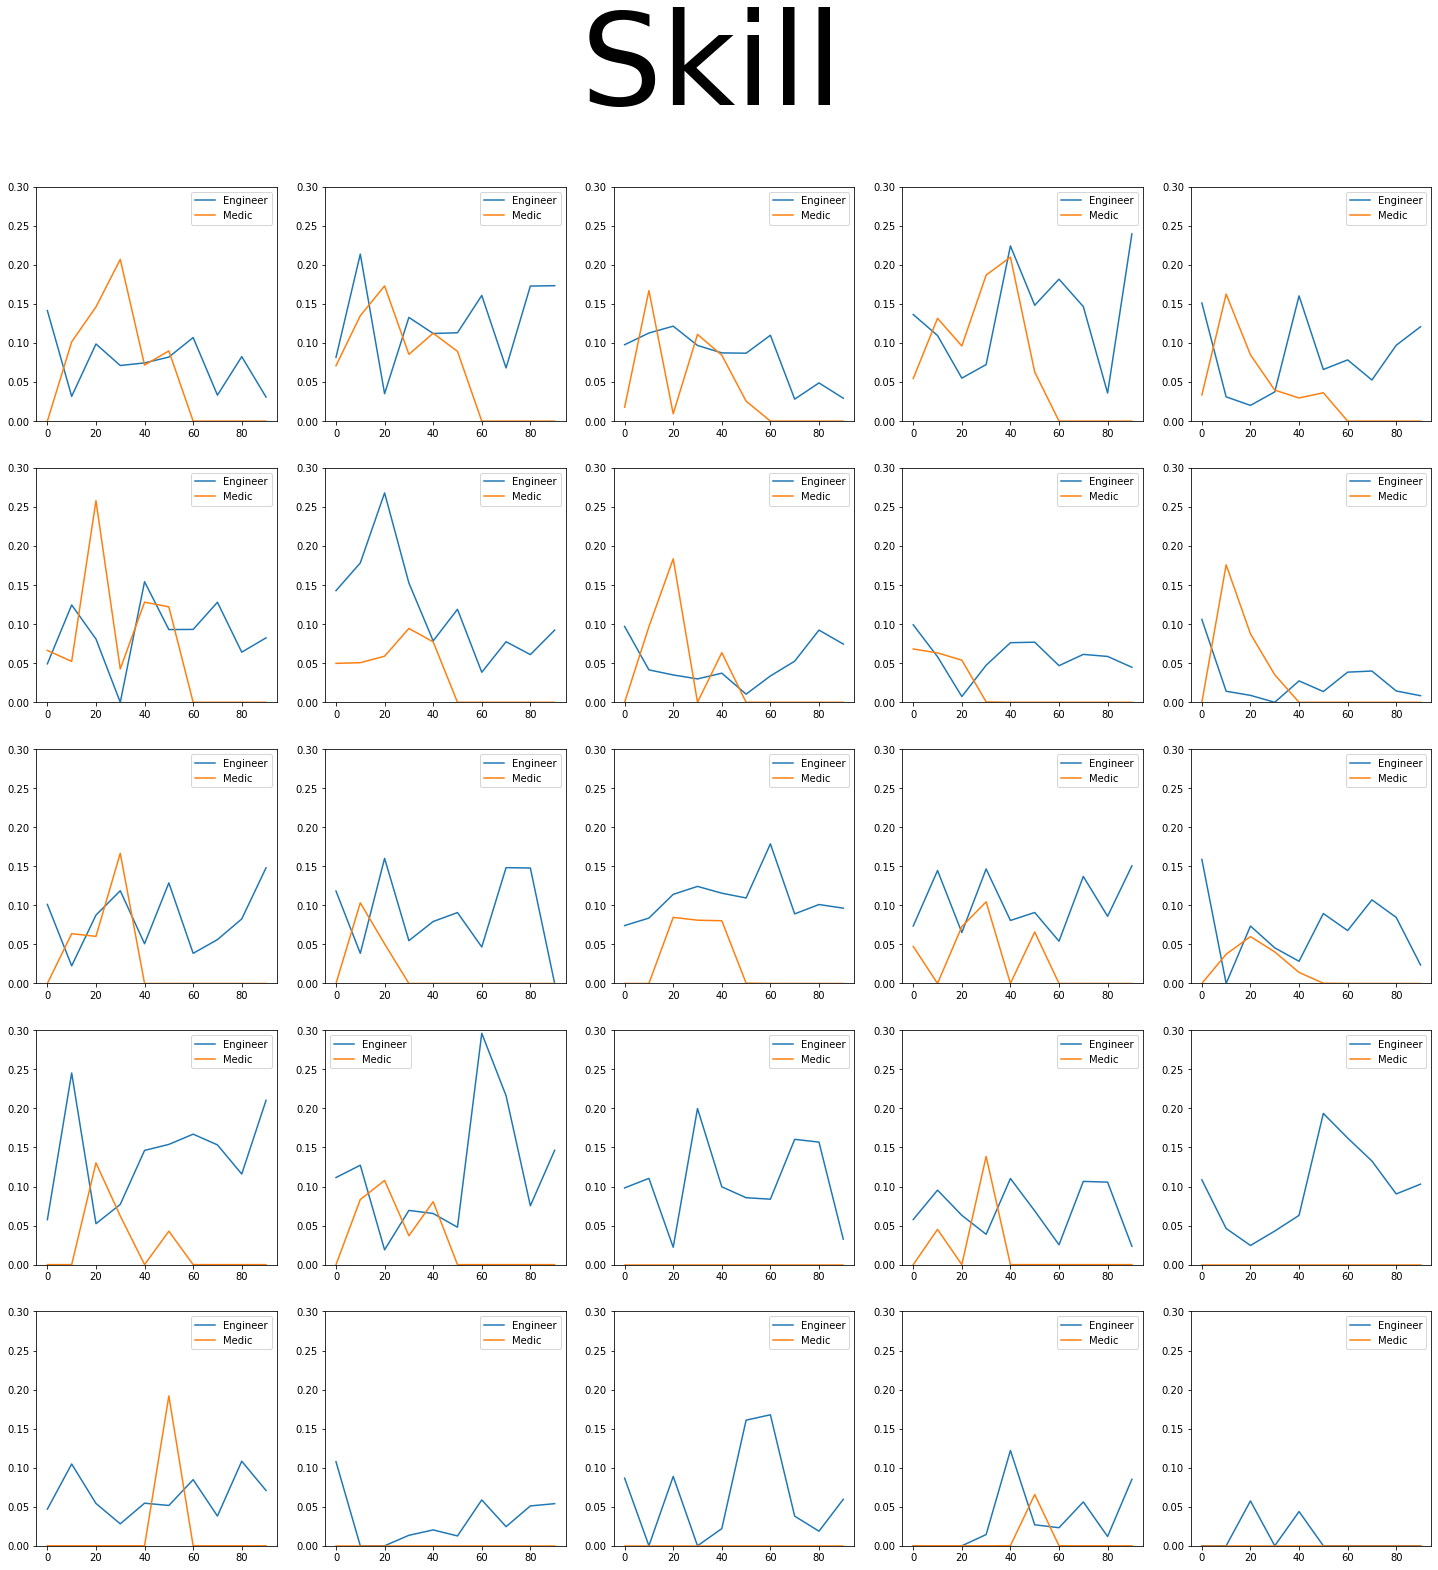

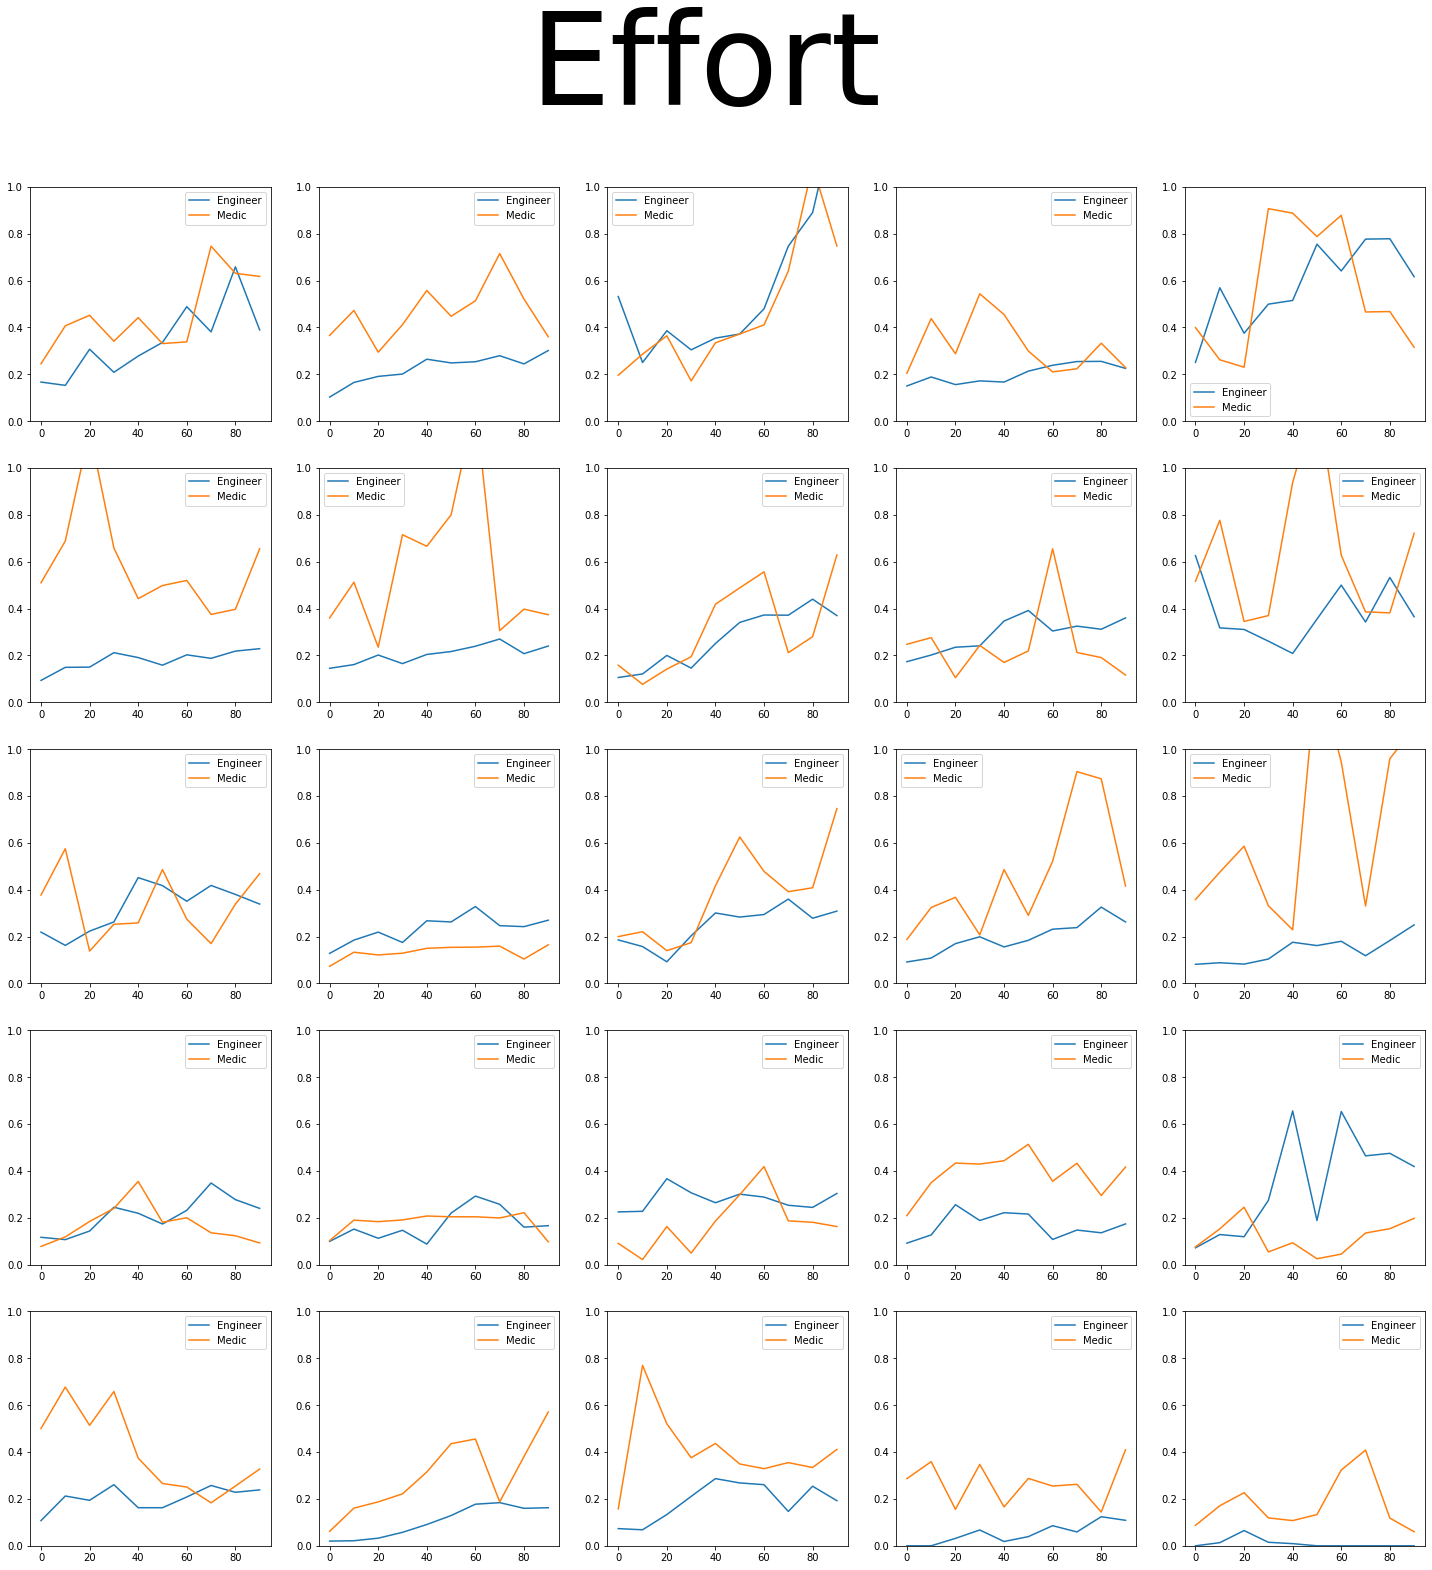

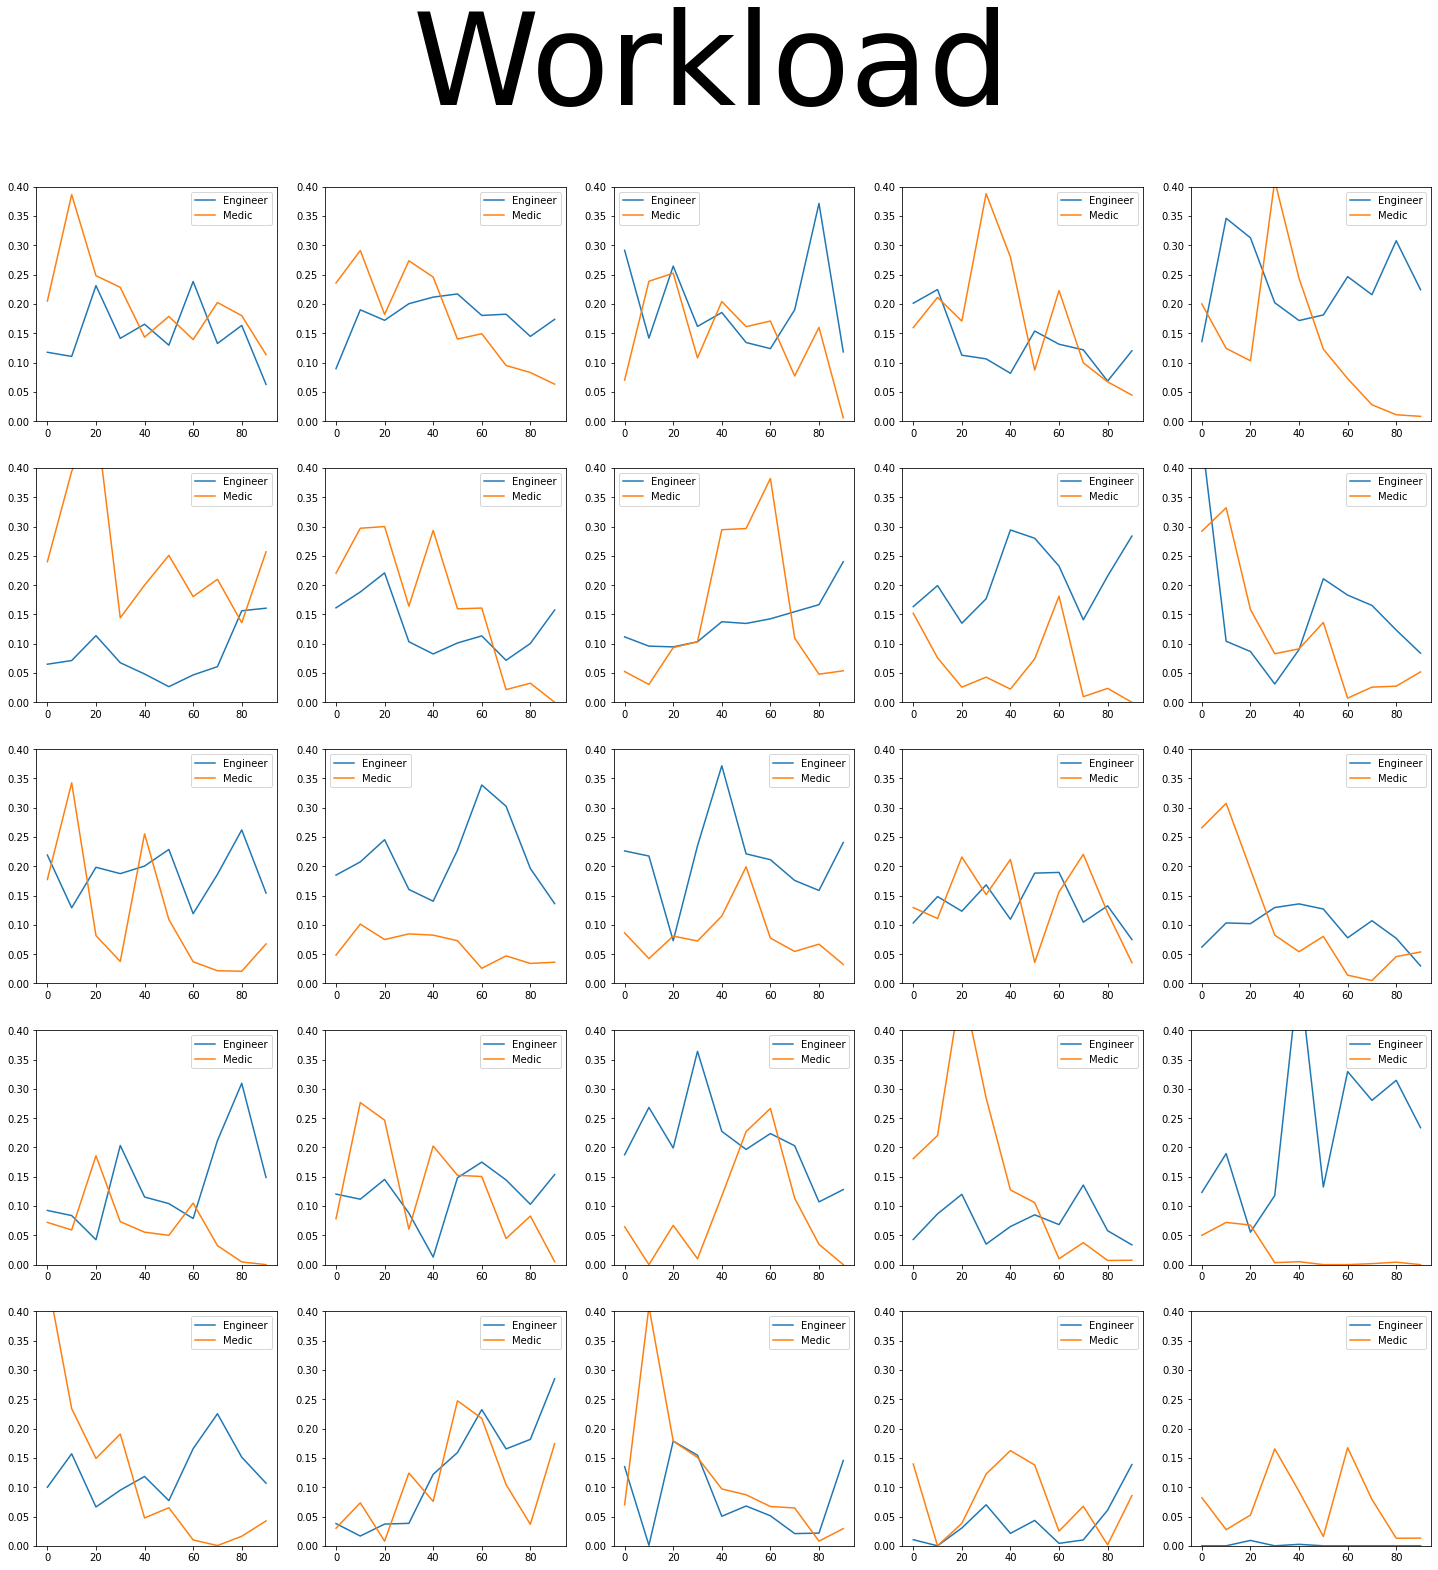

In [229]:
skill_fig, skill_axis = plt.subplots(5, 5)
skill_fig.set_size_inches(25, 25)

effort_fig, effort_axis = plt.subplots(5, 5)
effort_fig.set_size_inches(25, 25)

workload_fig, workload_axis = plt.subplots(5, 5)
workload_fig.set_size_inches(25, 25)

for group in data.values():

    row = math.floor(group['rank']/5)
    column = group['rank']%5


    skill_axis[row, column].plot(df_eng_global['Time'], group['engs']['Skill'],label='Engineer')
    skill_axis[row, column].plot(df_med_global['Time'], group['meds']['Skill'],label='Medic')
    skill_axis[row, column].legend()
    skill_axis[row, column].set_ylim([0,0.3])


    workload_axis[row, column].plot(df_eng_global['Time'], group['engs']['Workload'],label='Engineer')
    workload_axis[row, column].plot(df_med_global['Time'], group['meds']['Workload'],label='Medic')
    workload_axis[row, column].legend()
    workload_axis[row, column].set_ylim([0,0.4])

    effort_axis[row, column].plot(df_eng_global['Time'], group['engs']['Effort'],label='Engineer')
    effort_axis[row, column].plot(df_med_global['Time'], group['meds']['Effort'],label='Medic')
    effort_axis[row, column].legend()
    effort_axis[row, column].set_ylim([0,1])

skill_fig.suptitle('Skill',fontsize=128)
skill_fig.savefig('skill', facecolor='w')


effort_fig.suptitle('Effort',fontsize=128)
effort_fig.savefig('Effort', facecolor='w')

workload_fig.suptitle('Workload',fontsize=128)
workload_fig.savefig('Workload', facecolor='w')

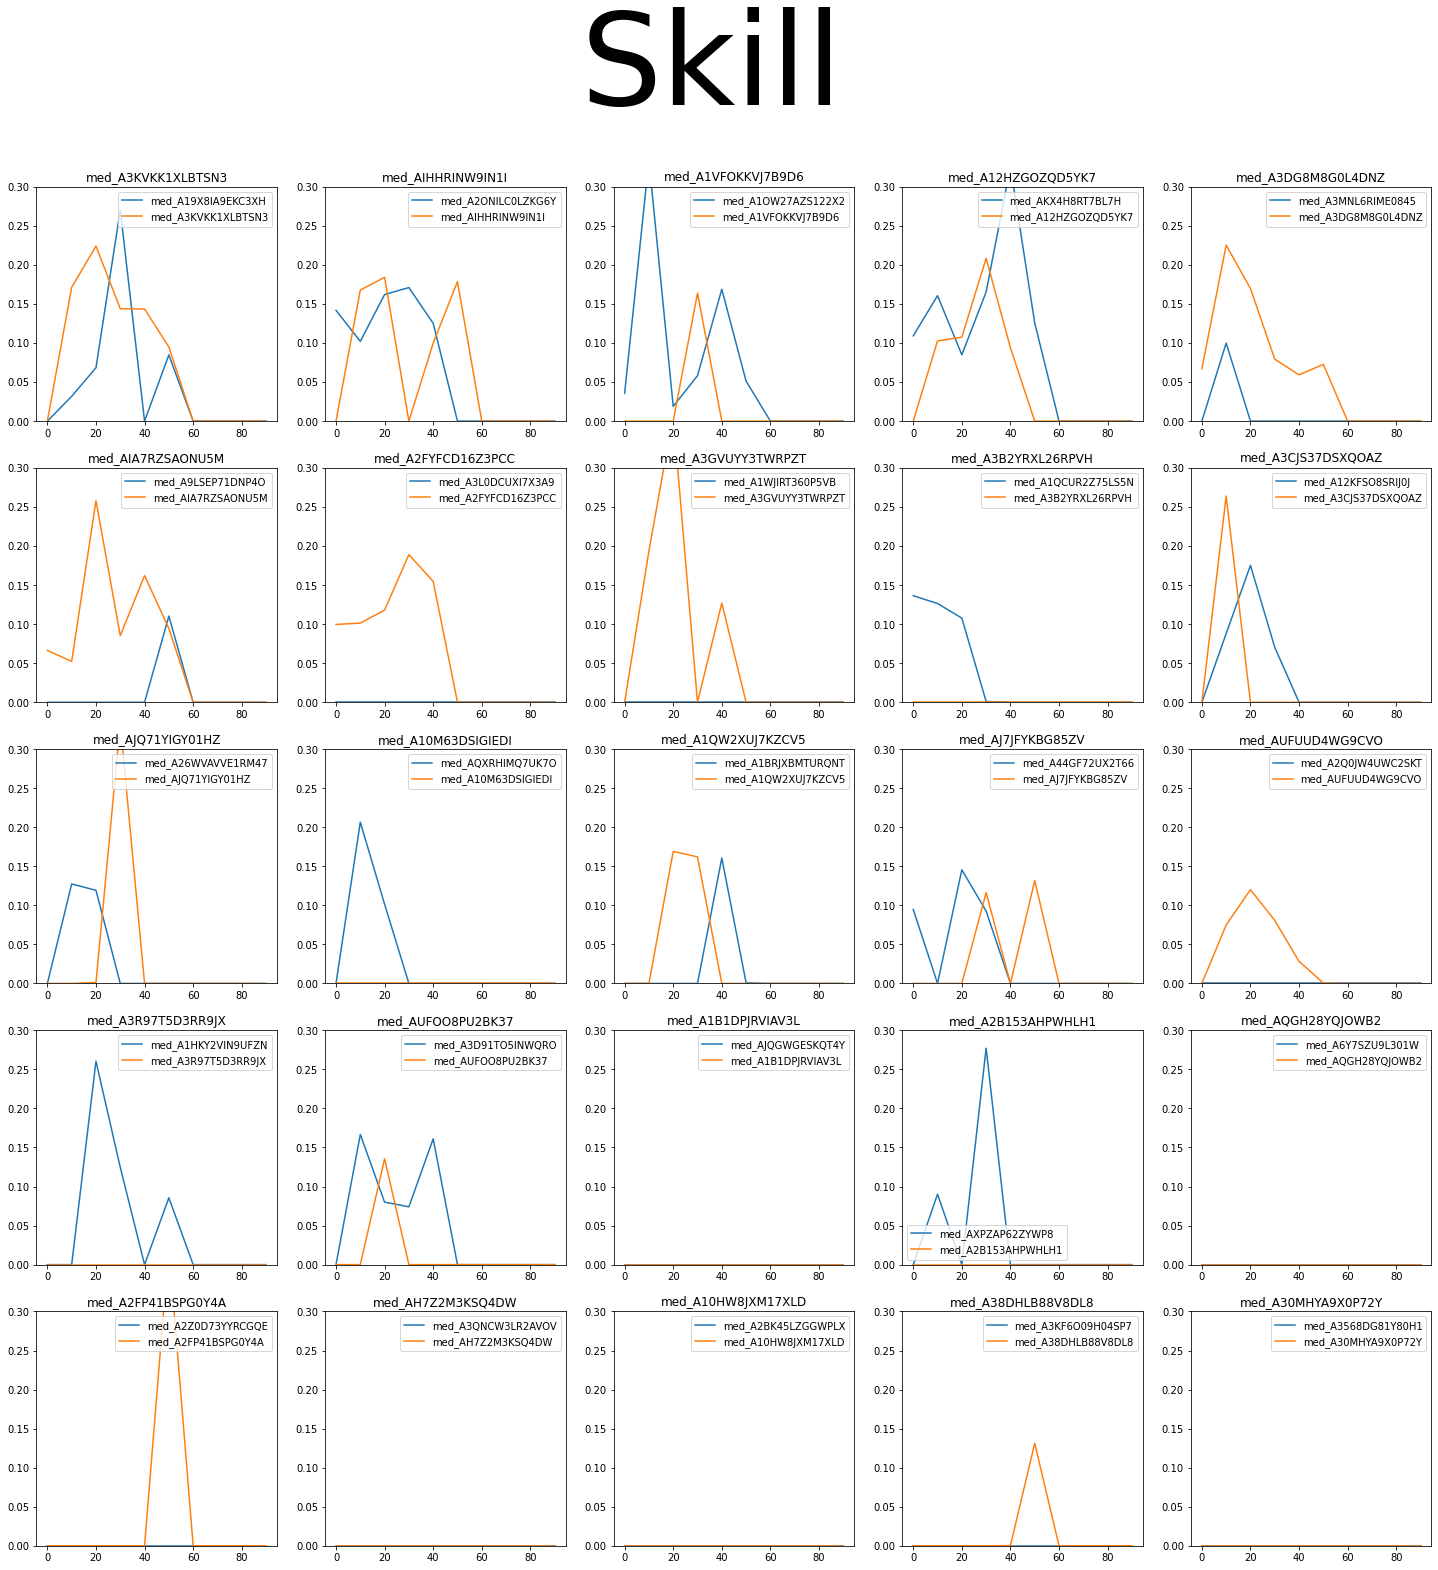

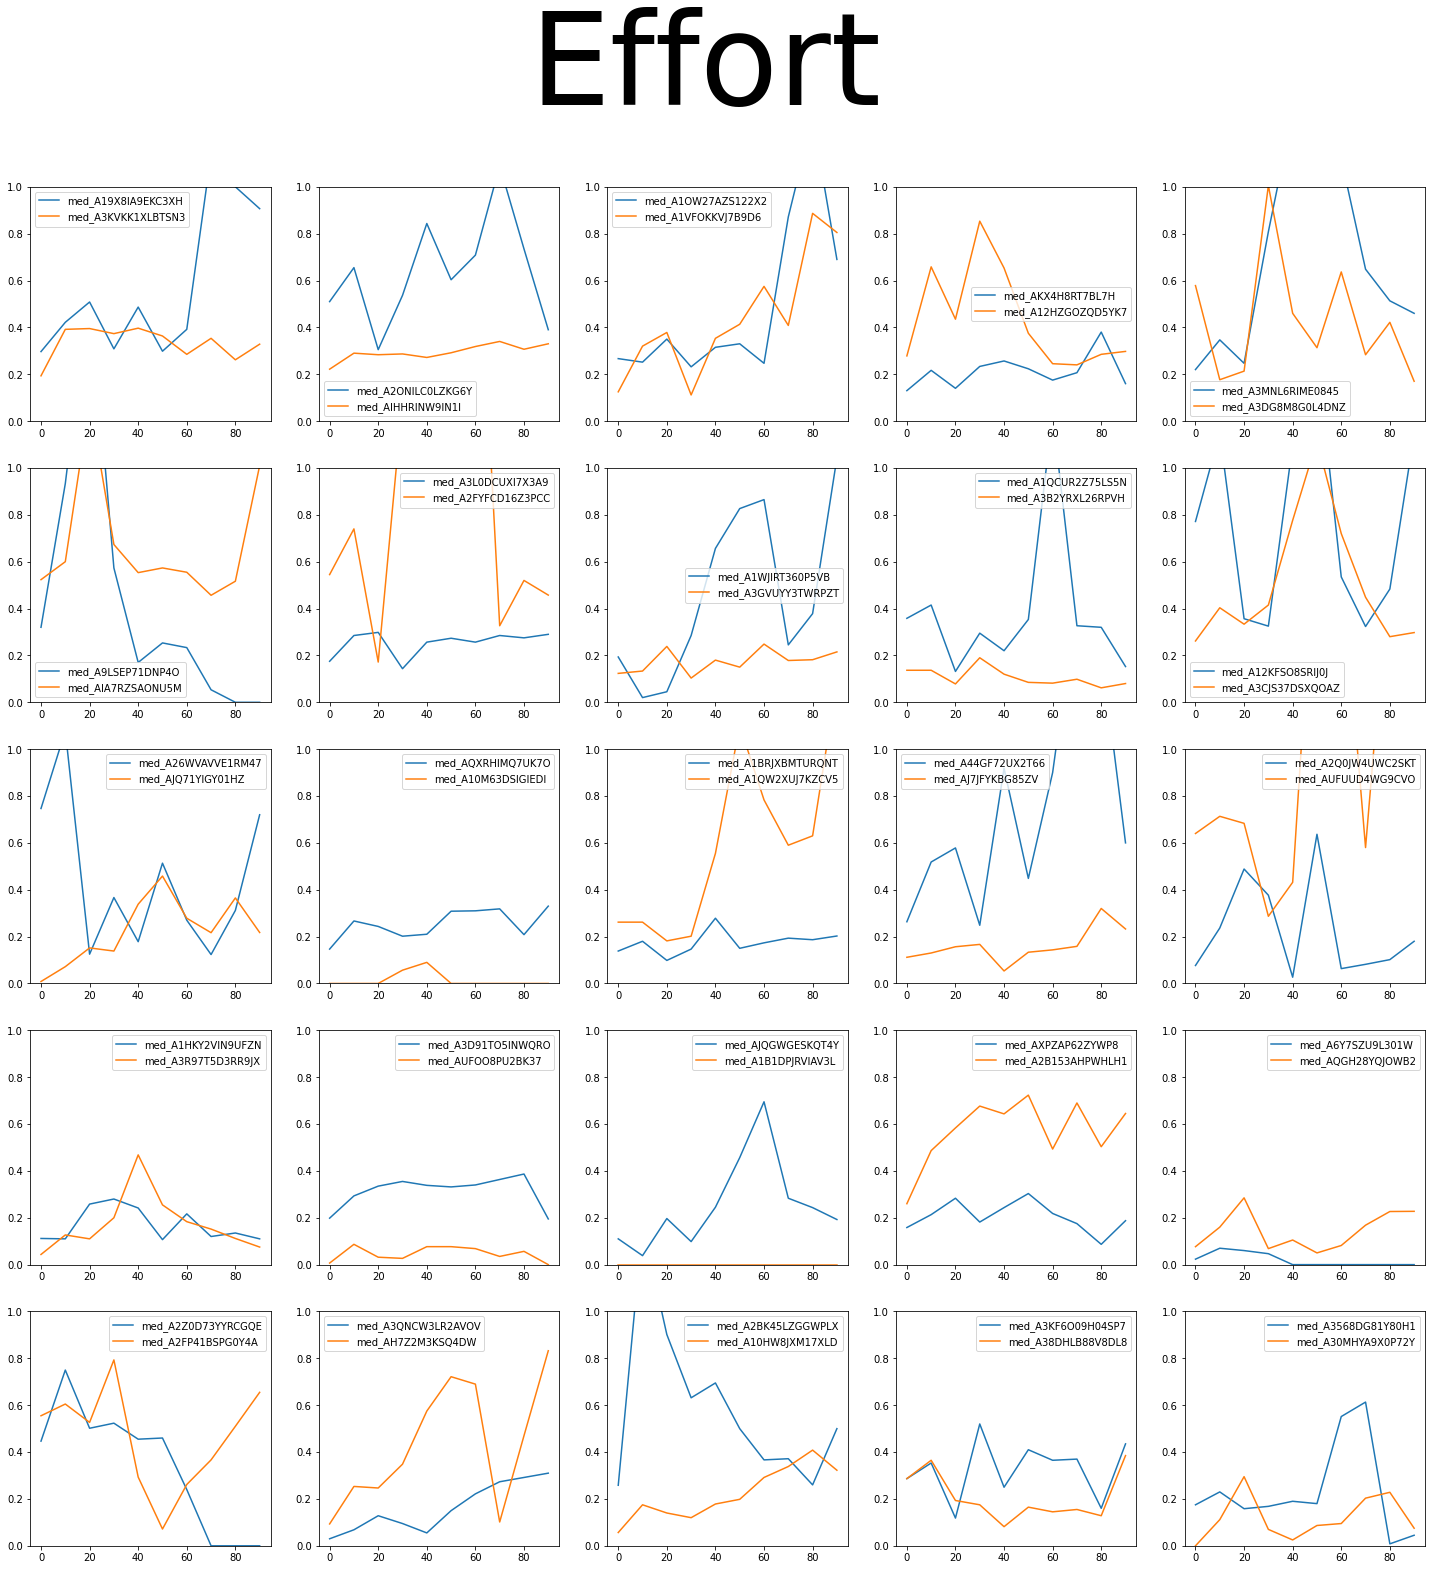

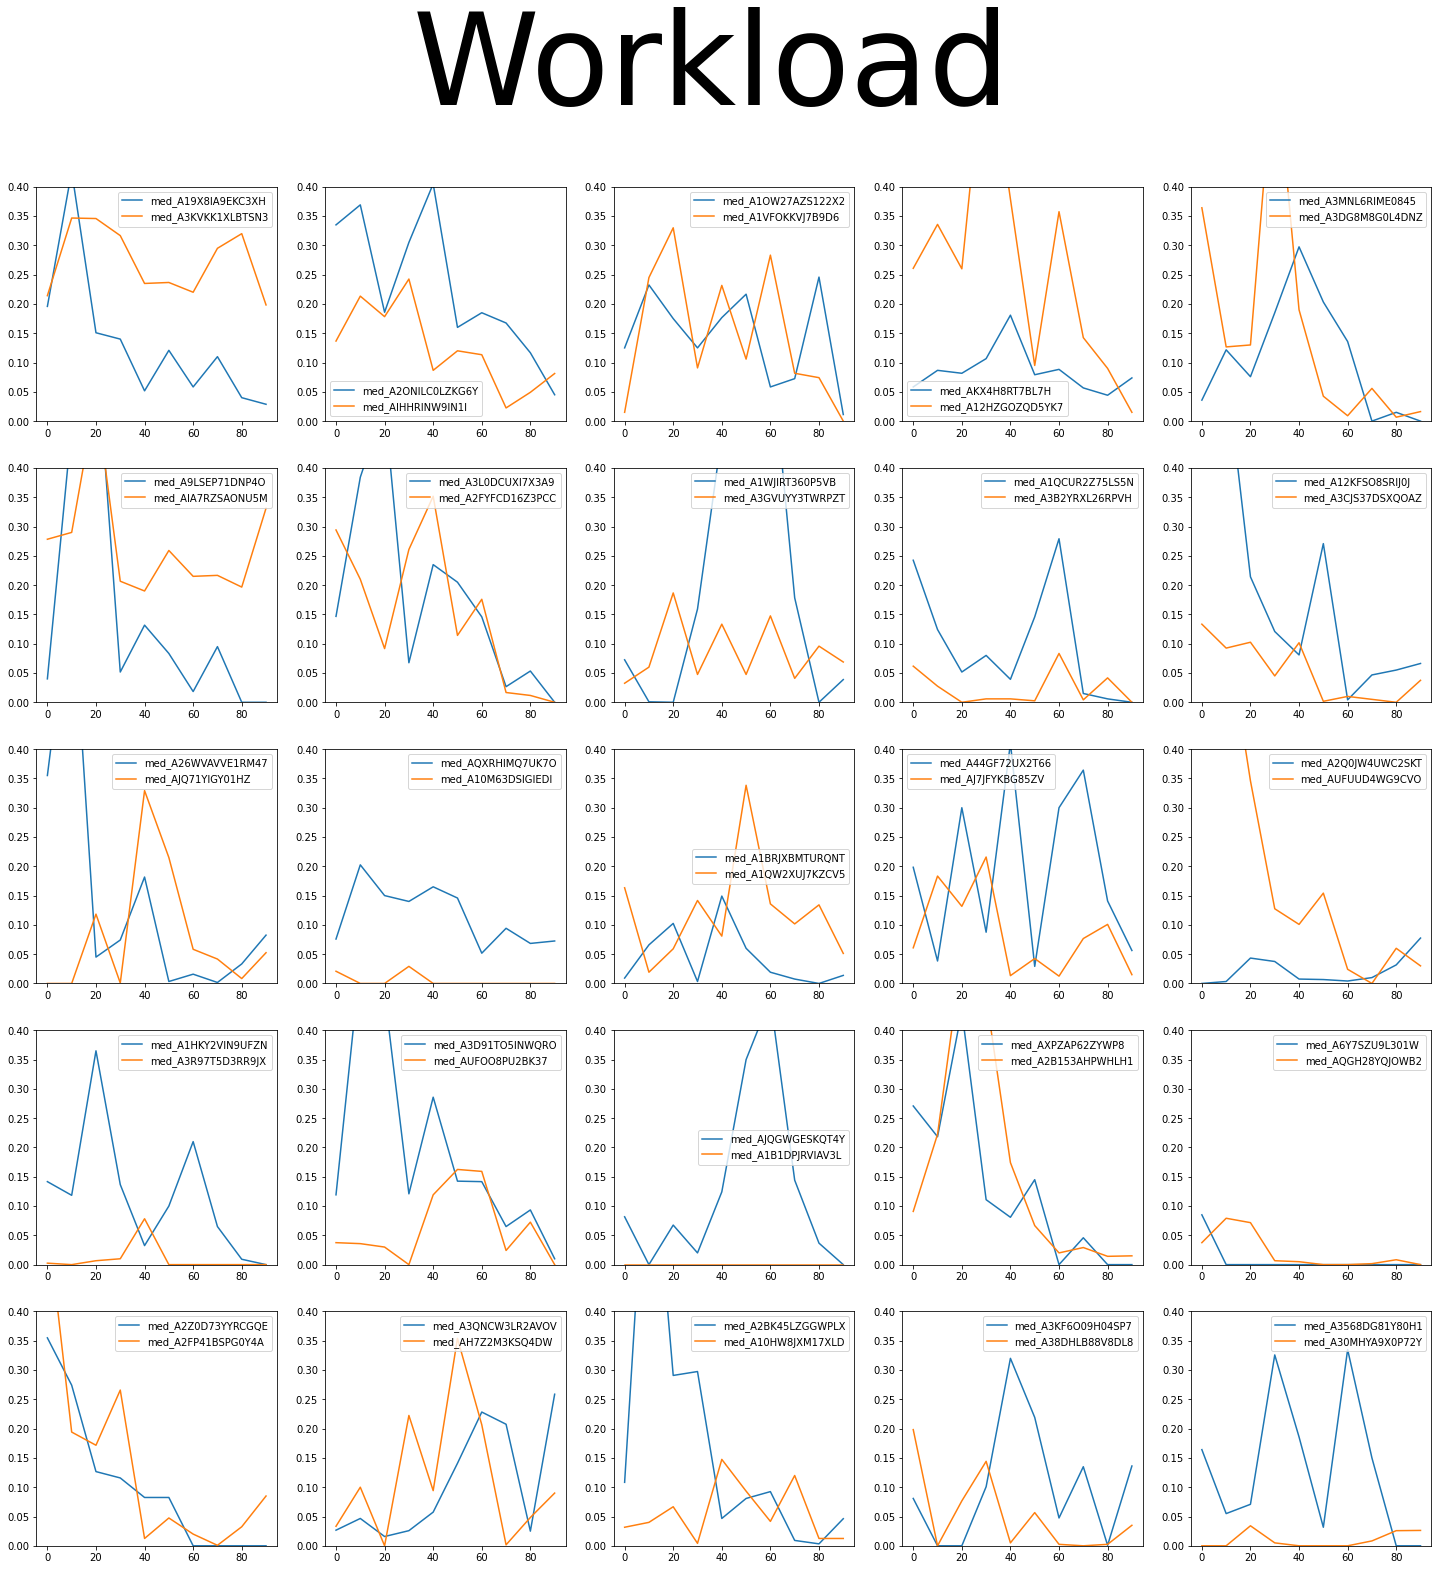

In [227]:
skill_fig, skill_axis = plt.subplots(5, 5)
skill_fig.set_size_inches(25, 25)

effort_fig, effort_axis = plt.subplots(5, 5)
effort_fig.set_size_inches(25, 25)

workload_fig, workload_axis = plt.subplots(5, 5)
workload_fig.set_size_inches(25, 25)

for group in data.values():
    for player in group:
        if not player.startswith('med_'):
            continue


        row = math.floor(group['rank']/5)
        column = group['rank']%5


        skill_axis[row, column].plot(df_eng_global['Time'], group[player]['Skill'],label=player)
        skill_axis[row, column].legend()
        skill_axis[row, column].set_ylim([0,0.3])


        workload_axis[row, column].plot(df_eng_global['Time'], group[player]['Workload'],label=player)
        workload_axis[row, column].legend()
        workload_axis[row, column].set_ylim([0,0.4])

        effort_axis[row, column].plot(df_eng_global['Time'], group[player]['Effort'],label=player)
        effort_axis[row, column].legend()
        effort_axis[row, column].set_ylim([0,1])

skill_fig.suptitle('Skill',fontsize=128)
skill_fig.savefig('Skill Eng', facecolor='w')


effort_fig.suptitle('Effort',fontsize=128)
effort_fig.savefig('Effort Eng', facecolor='w')

workload_fig.suptitle('Workload',fontsize=128)
workload_fig.savefig('Workload Eng', facecolor='w')

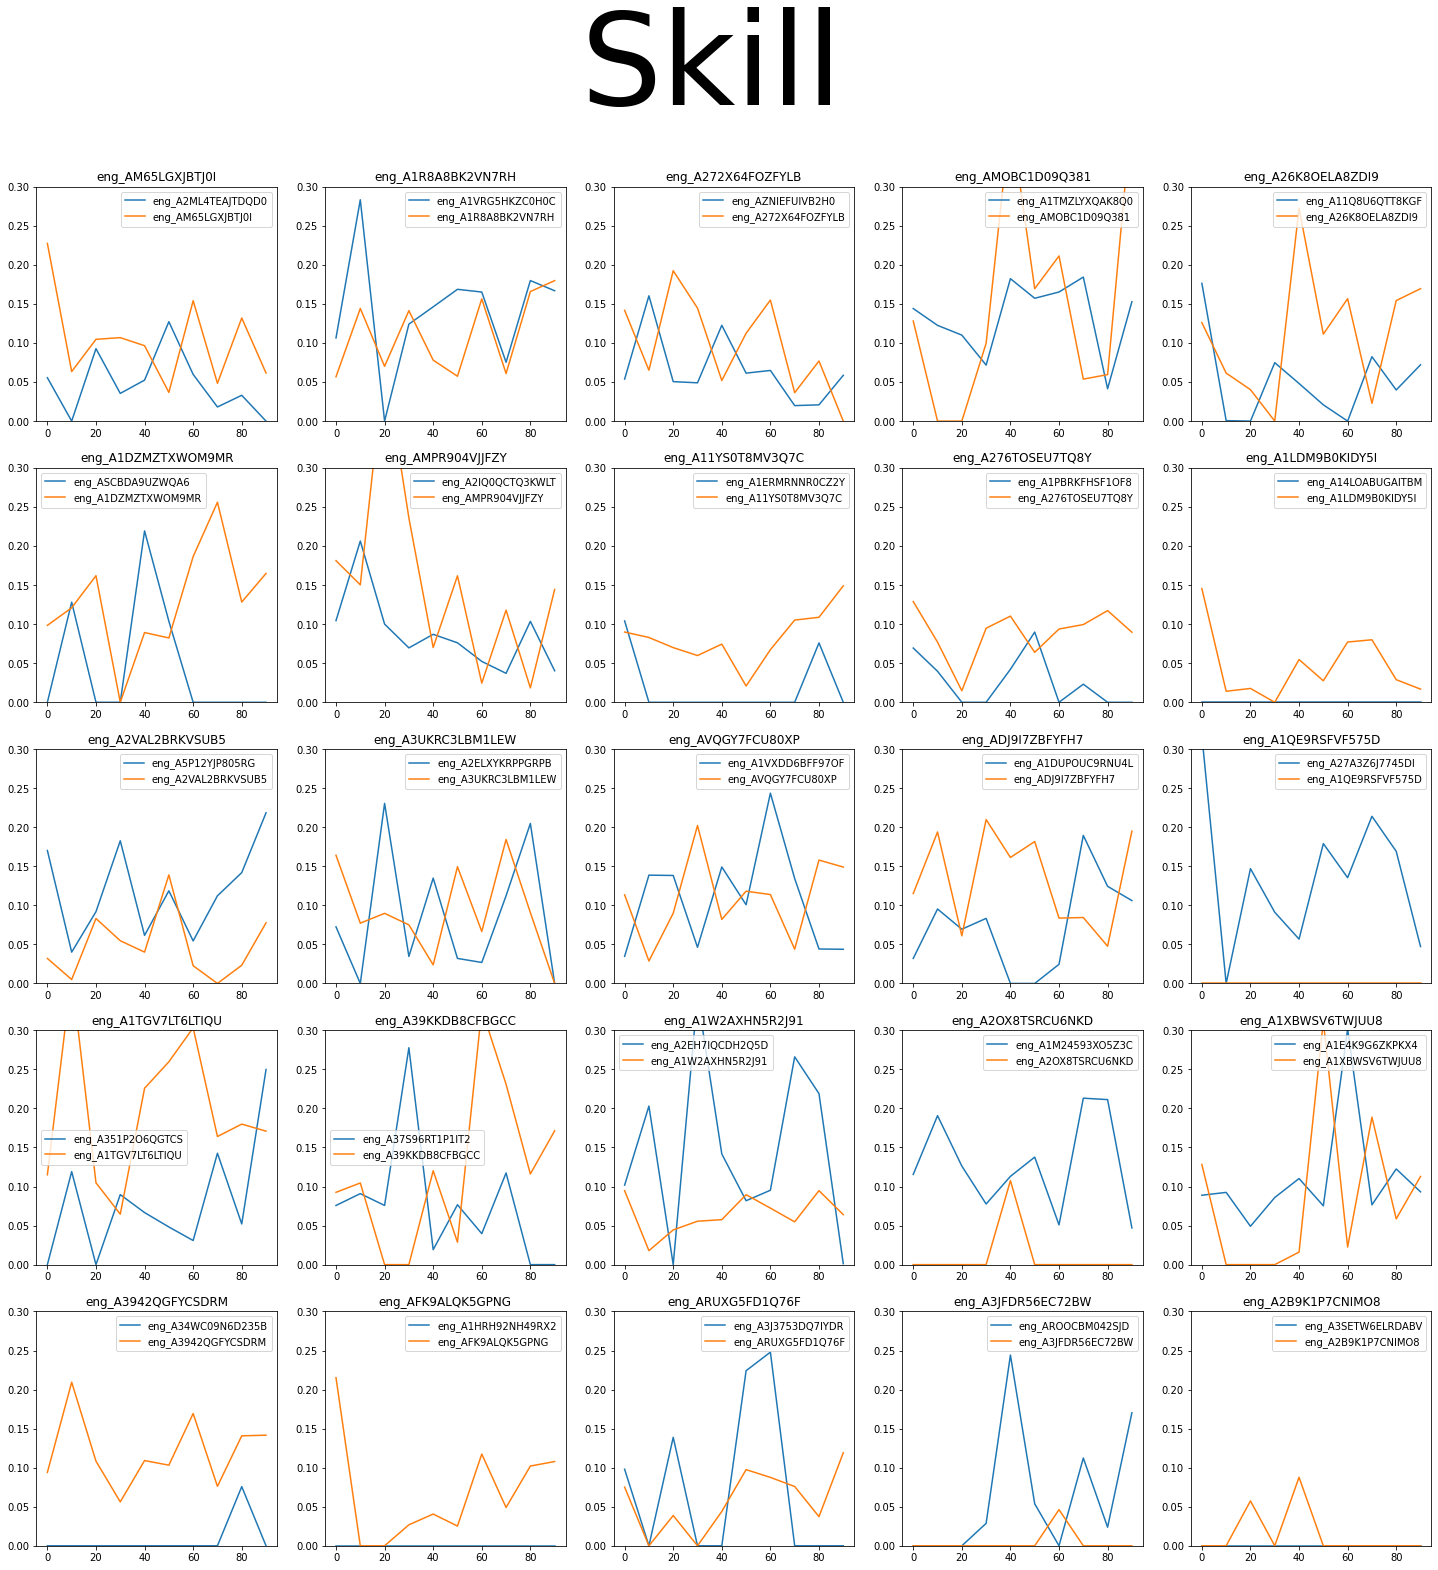

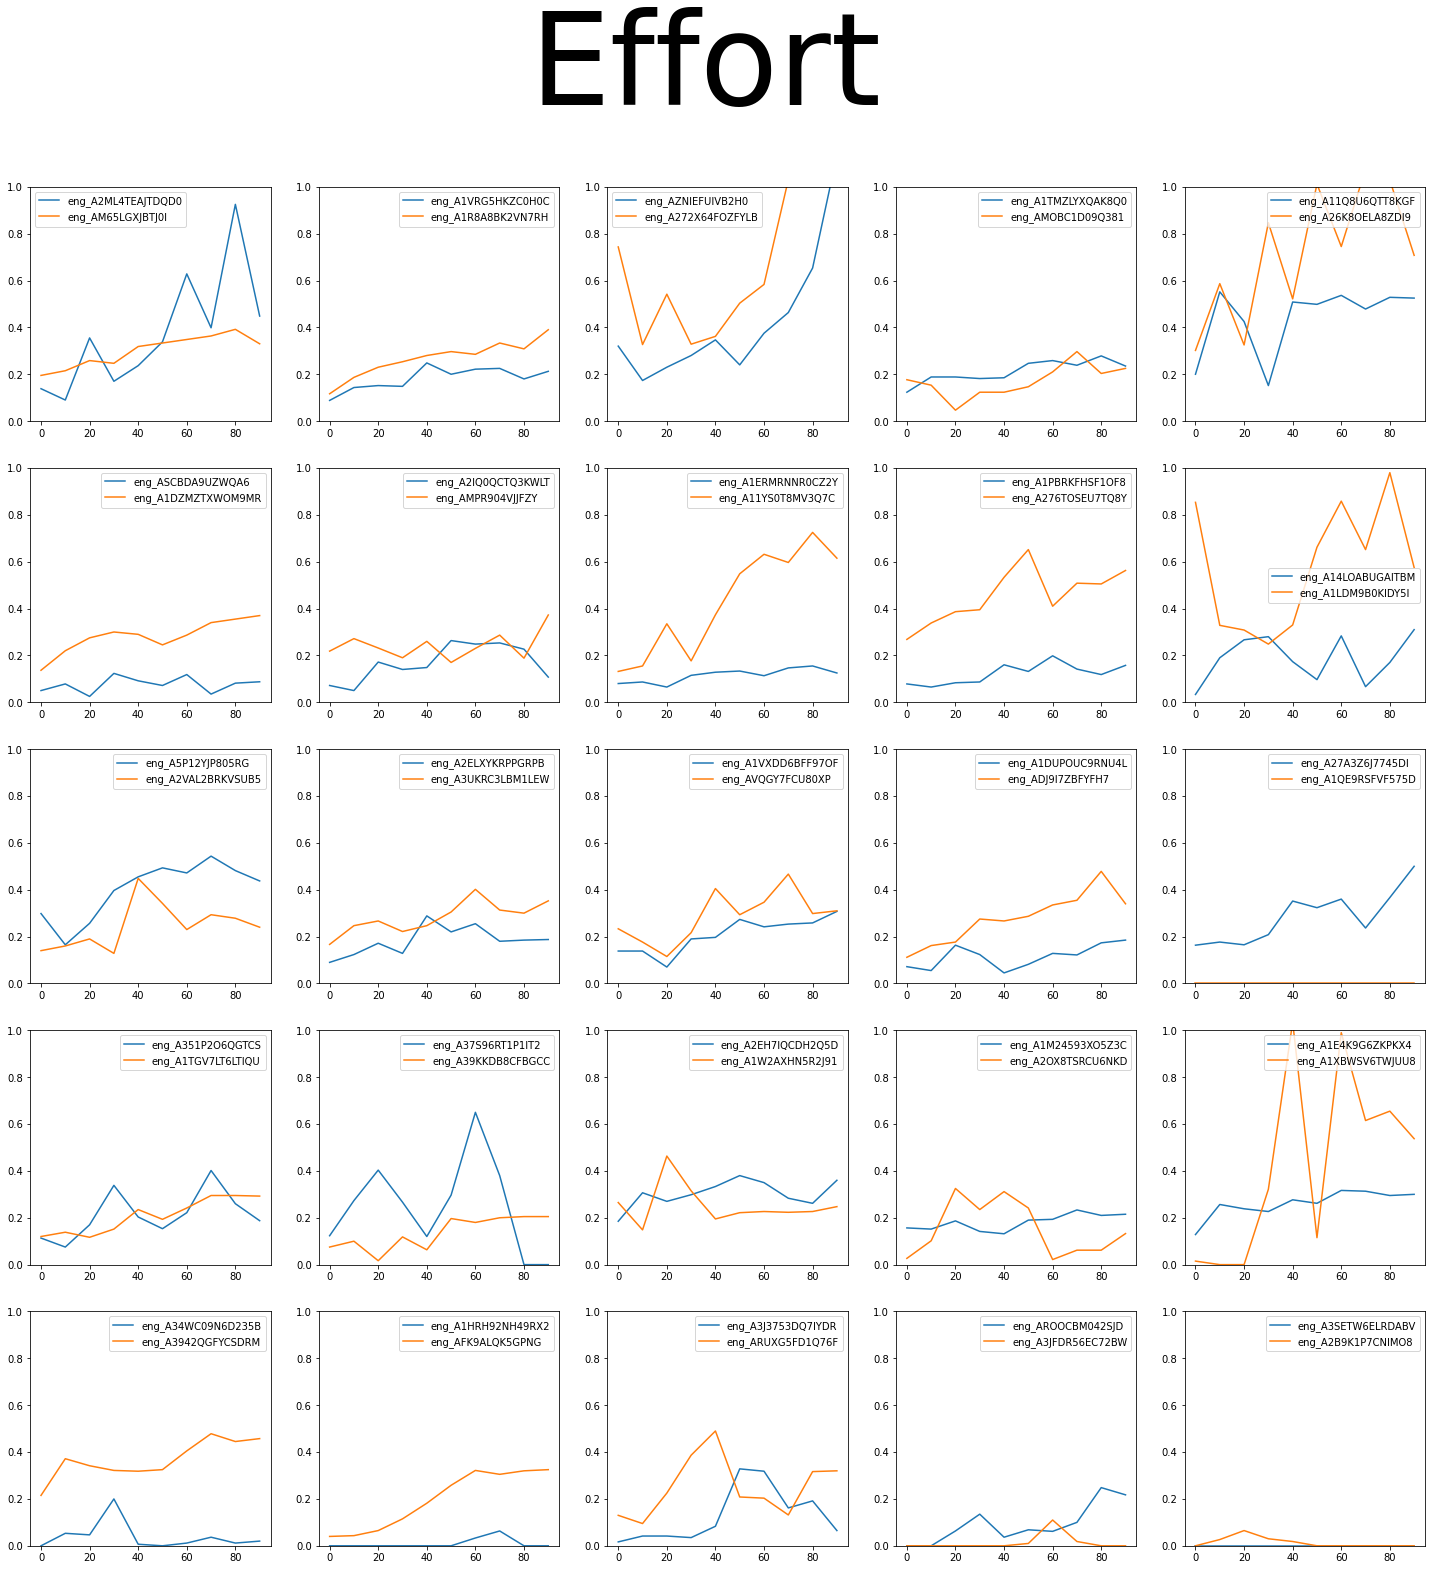

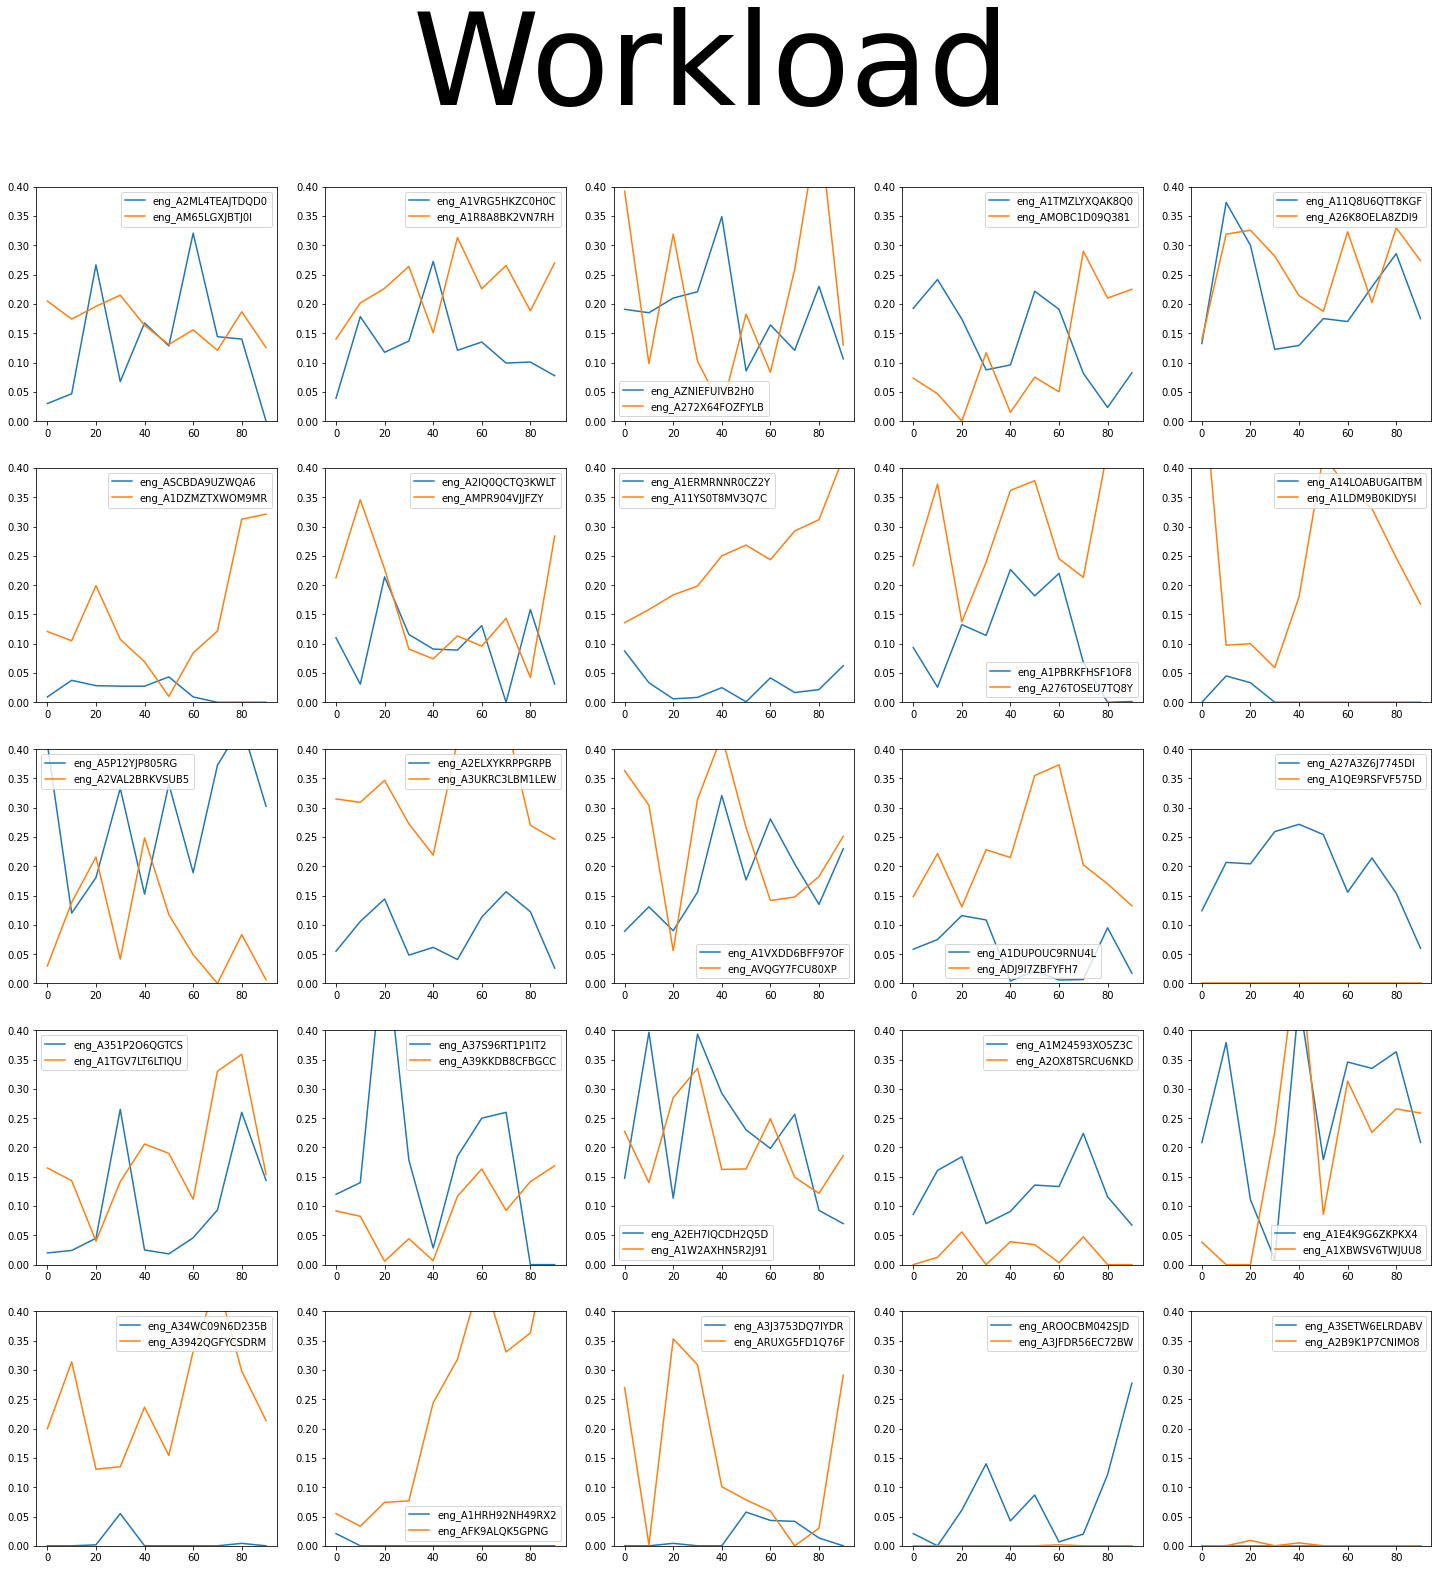

In [230]:
skill_fig, skill_axis = plt.subplots(5, 5)
skill_fig.set_size_inches(25, 25)

effort_fig, effort_axis = plt.subplots(5, 5)
effort_fig.set_size_inches(25, 25)

workload_fig, workload_axis = plt.subplots(5, 5)
workload_fig.set_size_inches(25, 25)

for group in data.values():
    for player in group:
        if not player.startswith('eng_'):
            continue


        row = math.floor(group['rank']/5)
        column = group['rank']%5


        skill_axis[row, column].plot(df_eng_global['Time'], group[player]['Skill'],label=player)
        skill_axis[row, column].legend()
        skill_axis[row, column].set_ylim([0,0.3])


        workload_axis[row, column].plot(df_eng_global['Time'], group[player]['Workload'],label=player)
        workload_axis[row, column].legend()
        workload_axis[row, column].set_ylim([0,0.4])

        effort_axis[row, column].plot(df_eng_global['Time'], group[player]['Effort'],label=player)
        effort_axis[row, column].legend()
        effort_axis[row, column].set_ylim([0,1])

skill_fig.suptitle('Skill',fontsize=128)
skill_fig.savefig('Skill Eng', facecolor='w')


effort_fig.suptitle('Effort',fontsize=128)
effort_fig.savefig('Effort Eng', facecolor='w')

workload_fig.suptitle('Workload',fontsize=128)
workload_fig.savefig('Workload Eng', facecolor='w')